## STAT 5243 Project 4 

### Team Members Group 6

	+ Agarwal, Rishav ra3141
	+ Liao, Jingwei jl5983
	+ Liu, Ke kl3344
	+ Wang, Jiuru jw4150
	+ Wang, Xinran xw2809

## A3:  Fairness Constraints: Mechanisms for Fair Classification

In [4]:
#Load data 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import log_loss
from scipy import optimize
import copy
import itertools
import math
from sklearn.svm import SVC
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

### Writing all the important functions as given by the Paper

In [5]:
def p_rule_percent(sensitive_col, y_predicted):
    #Calculating the P% as given by the paper
    #Protected are those between age 25 and 60 = 1
    #Unprotected are = 0 

    protected = np.where(sensitive_col == 1)[0]  #gives us the index of the protected
    unprotected = np.where(sensitive_col != 1)[0] #gives us the index of the unprotected
    prediction_protected = np.where(y_predicted[protected]==1)
    prediction_unprotected = np.where(y_predicted[unprotected]==1)

    total_protected = protected.shape[0]
    total_unprotected = unprotected.shape[0]

    total_protected_pred = prediction_protected[0].shape[0]
    total_unprotected_pred = prediction_unprotected[0].shape[0]
    #print(total_protected_pred)

    protected_ratio = total_protected_pred/total_protected
    unprotected_ratio = total_unprotected_pred/total_unprotected
    
    p_percent_ratio = protected_ratio/unprotected_ratio
    return p_percent_ratio, protected_ratio, unprotected_ratio 
    #print("P%: ", round(p_percent_ratio*100,2),"%")

In [6]:
#Optmization function

def optimize_function(w, x, protected_var):
    dist_bound = np.dot(w, X_train.T)
    protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
    return float(abs(sum(protected_cov))) / float(X_train.shape[0])

#On page 4, equation (5) we get the logistic loss  

#Fined-Grained Accuracy Constraint
#Page 5 Equation 8

def log_loss_constraint(weights, x, y, gamma):
    #print(weights.shape)
    prod = np.dot(x, weights.reshape(X_train.shape[1],1))
    pred_probability = 1/(1+np.exp(-prod))
    predicted_classes = np.concatenate((1-pred_probability, pred_probability), axis = 1)
    loss = log_loss(y, predicted_classes)
    return (1+gamma)*actual_train_loss - loss 

In [7]:
#Accuracy Calculation
def accuracy(w, x, y):
    shape = x.shape[1]
    pred = np.dot(x, w.reshape(x.shape[1],1))
    pred_prob = 1/(1+ np.exp(-pred))
    pred_prob[pred_prob>=0.5] = 1
    pred_prob[pred_prob<0.5] = 0
    value = np.where(pred_prob== y.reshape(pred_prob.shape))
    accuracy = value[0].shape[0]/pred_prob.shape[0]
    return accuracy, pred_prob

We will use the optimization reference provided in the link [https://towardsdatascience.com/optimization-with-scipy-and-application-ideas-to-machine-learning-81d39c7938b8]. This uses the concept of scipy optimization to add constraints as a pre-defined function.  
<br>
For the optimization method, SLSQP method is used which stands for Sequential Least-Square Quadratic Programming. We will do the number of iterations of 1000, and then add the optimization function and the log loss constraint as the parameters. 

In [8]:
def optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    cons = {'type':'ineq', 'fun': log_loss_constraint, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(optimize_function,
                               x0=optimal_weights,
                               args= (x_train,protected_attr),
                               method='SLSQP',
                               constraints=cons,
                               options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule_percent(protected_attr, pred_y)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule_percent(protected_attr_test, y_pred_test)
    
    print("\nTest Accuracy for gamma ",gamma,": ",accuracy_test)
    print("P Rule percent: ", p_rule_val_test)
    
    return accuracy_train,pred_y, p_rule_val, accuracy_test, p_rule_val_test, y_pred_test


The paper implements the Algorithm (3) on the Bank data to showcase how the model constraints were put into place. So let us first implement the algorithm mentioned by them on the Bank data. Then we will move on to the COMPAS Dataset. 

### Evaluation on the Bank data as per the paper

In [9]:
df_bank = pd.read_csv("data/bank-full.csv", delimiter=";")
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [10]:
df_bank = df_bank.dropna()
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
target = encoder.fit_transform(df_bank['y'])
sensitive_age = df_bank["age"].apply(lambda x: 1 if 25<= x <= 60 else 0)
df_bank = df_bank.drop(columns = ["age", "y", "day", "month"])

In [12]:
columns = ['job', 'marital', 'education','contact','poutcome']
for c in columns: 
    dummies = pd.get_dummies(df_bank[c])
    df_bank = pd.merge(df_bank, dummies, left_index = True, right_index = True)
    df_bank = df_bank.drop(columns = [c])
df_bank

,default,balance,housing,loan,duration,campaign,pdays,previous,admin.,blue-collar,...,secondary,tertiary,unknown_y,cellular,telephone,unknown_x,failure,other,success,unknown_y
0,no,2143,yes,no,261,1,-1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,no,29,yes,no,151,1,-1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,no,2,yes,yes,76,1,-1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,no,1506,yes,no,92,1,-1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4,no,1,no,no,198,1,-1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,no,825,no,no,977,3,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
45207,no,1729,no,no,456,2,-1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,no,5715,no,no,1127,5,184,3,0,0,...,1,0,0,1,0,0,0,0,1,0
45209,no,668,no,no,508,4,-1,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [13]:
#Encoding the categorical values

df_bank['default'] = encoder.fit_transform(df_bank['default'])
df_bank['housing'] = encoder.fit_transform(df_bank['housing'])
df_bank['loan'] = encoder.fit_transform(df_bank['loan'])


In [14]:
df_bank, target, sensitive_age = shuffle(df_bank, target, sensitive_age, random_state=123) #randomizing and shuffling  

In [15]:
df_bank

,default,balance,housing,loan,duration,campaign,pdays,previous,admin.,blue-collar,...,secondary,tertiary,unknown_y,cellular,telephone,unknown_x,failure,other,success,unknown_y
7281,0,589,1,0,535,2,-1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
19469,0,649,0,0,64,2,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
31637,0,1972,0,0,97,1,-1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
22484,0,1,0,0,239,4,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
35919,0,-808,1,0,75,4,-1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0,3674,1,0,886,3,-1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
15377,0,635,1,0,359,1,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
17730,0,3664,0,0,274,1,-1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
28030,0,8585,0,0,201,2,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [16]:
df_bank = df_bank.to_numpy()
sensitive_age = sensitive_age.to_numpy()

In [17]:
X = df_bank
Y = target
train_test_split = int(len(X)*.80) 
X_train1 =X[:train_test_split]
Y_train1 = Y[:train_test_split]
sensitive_age_train1 = sensitive_age[:train_test_split]

X_test =X[train_test_split:]
Y_test = Y[train_test_split:]
sensitive_age_test = sensitive_age[train_test_split:]

train_test_split = int(len(X_train1)*.75) 
X_train =X_train1[:train_test_split]
Y_train = Y_train1[:train_test_split]
sensitive_age_train = sensitive_age_train1[:train_test_split]

X_val =X_train1[train_test_split:]
Y_val = Y_train1[train_test_split:]
sensitive_age_val = sensitive_age_train1[train_test_split:]

In [18]:
print("Bank Dataset!")
print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_val Shape: ", X_val.shape)
print("Y_val Shape: ", Y_val.shape)
print("X_test Shape: ", X_test.shape)
print("X_test Shape: ", Y_test.shape)

Bank Dataset!
X_train Shape:  (27126, 34)
Y_train Shape:  (27126,)
X_val Shape:  (9042, 34)
Y_val Shape:  (9042,)
X_test Shape:  (9043, 34)
X_test Shape:  (9043,)


In [19]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, Y_train)
print(classification_report(Y_val, lr.predict(X_val)))   #Working on the validation data

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      8017
           1       0.59      0.22      0.32      1025

    accuracy                           0.89      9042
   macro avg       0.75      0.60      0.63      9042
weighted avg       0.87      0.89      0.87      9042



In [20]:
train_accuracy = lr.score(X_train, Y_train)
val_accuracy = lr.score(X_val, Y_val)

In [21]:
print("Training Accuracy: ", train_accuracy)
print("Validation Accuracy: ", val_accuracy)

Training Accuracy:  0.8913219789132197
Validation Accuracy:  0.8944923689449237


In [22]:
y_predicted = lr.predict(X_train)

In [23]:
p_percent, protected_ratio, unprotected_ratio = p_rule_percent(sensitive_age_train, y_predicted)

In [24]:
print("P% for the Bank Dataset without optimization: ",round(p_percent*100,2),"%")


P% for the Bank Dataset without optimization:  39.24 %


In [25]:
actual_train_loss = log_loss(Y_train, lr.predict_proba(X_train))
print("Actual Train Loss: ", actual_train_loss)

Actual Train Loss:  0.26739769270167046


In [26]:
#Now s=we start with the optimization as described in the paper
#Adding a Bias_factor to the data for the decision boundary

bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_val = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)

X_val =  np.concatenate((X_val, bias_factor_val), axis = 1)
X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)

In [27]:
#Creating the Weights Dataframe
weights_df = np.concatenate((lr.coef_, lr.intercept_.reshape(1,1)),axis=1)

### Perform Hyperparamter Tuning with Different Gammas

In [28]:
gamma_list = [0.1,0.15,0.2, 0.25]

accuracy_list, p_list =  [],[]
y_pred_train_list = []
y_pred_test_list = []
accuracy_list_test, p_test = [],[]
for g in gamma_list:    
    (accuracy_train, pred_y, p_rule_val, accuracy_test, p_rule_val_test, y_pred_test) = optimization(X_train, 
                                                                                    Y_train, 
                                                                                    X_test, 
                                                                                    Y_test, 
                                                                                    sensitive_age_train,
                                                                                    sensitive_age_test,
                                                                                    g,
                                                                                    weights_df)
                                                                                     
    accuracy_list.append(accuracy_train)
    y_pred_train_list.append(pred_y)
    p_list.append(p_rule_val)

    accuracy_list_test.append(accuracy_test)
    y_pred_test_list.append(y_pred_test)
    p_test.append(p_rule_val_test)


Test Accuracy for gamma  0.1 :  0.8966051089240297
P Rule percent:  0.7831364991517188

Test Accuracy for gamma  0.15 :  0.893177043016698
P Rule percent:  1.0238671739882395

Test Accuracy for gamma  0.2 :  0.8888643149397324
P Rule percent:  1.0025366078634843

Test Accuracy for gamma  0.25 :  0.8875373216852814
P Rule percent:  1.6211230254813789


Train Accuracy and P% Rule


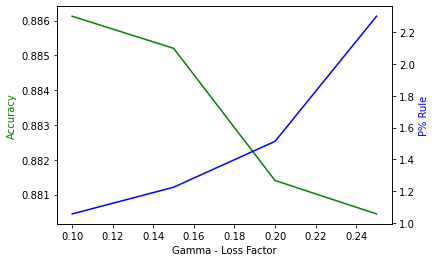

In [29]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list , 'g-')
ax2.plot(gamma_list, p_list, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Train Accuracy and P% Rule


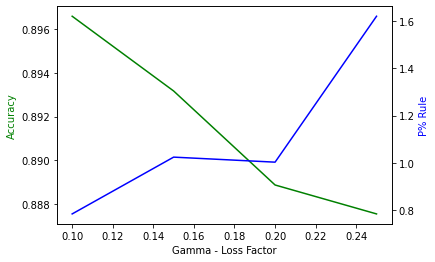

In [30]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list_test , 'g-')
ax2.plot(gamma_list, p_test, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

### COMPAS Dataset

In [150]:
import pandas as pd
import numpy as np
import math
import copy
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(18, 16), dpi=180)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

<Figure size 3240x2880 with 0 Axes>

In [151]:
link = ('https://raw.githubusercontent.com/'
        'propublica/compas-analysis/master/compas-scores-two-years.csv')
feature = ['age', 'c_charge_degree', 'race', 'v_score_text', 'sex', 'priors_count', 
           'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid','c_jail_in', 'c_jail_out']
raw = pd.read_csv(link)[feature]
raw

,age,c_charge_degree,race,v_score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Medium,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,Low,Male,2,NaN,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,F,African-American,Medium,Male,0,-1.0,7,0,0,2013-11-22 05:18:27,2013-11-24 02:59:20
7210,23,F,African-American,Medium,Male,0,-1.0,3,0,0,2014-01-31 07:13:54,2014-02-02 04:03:52
7211,57,F,Other,Low,Male,0,-1.0,1,0,0,2014-01-13 05:48:01,2014-01-14 07:49:46
7212,33,M,African-American,Low,Female,3,-1.0,2,0,0,2014-03-08 08:06:02,2014-03-09 12:18:04


In [152]:
df = raw[(raw.race == 'Caucasian') | (raw.race == 'African-American')]
df = df[(df.days_b_screening_arrest < 30) & (df.days_b_screening_arrest >= -30)]
df.drop(columns=['days_b_screening_arrest'], inplace = True)
df = df[df.is_recid != -1]
df = df[df.c_charge_degree != 'O']
df['length_of_stay'] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df['c_jail_in'])).dt.days
df.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)

df

,age,c_charge_degree,race,v_score_text,sex,priors_count,decile_score,is_recid,two_year_recid,length_of_stay
1,34,F,African-American,Low,Male,0,3,1,1,10
2,24,F,African-American,Low,Male,4,4,1,1,1
6,41,F,Caucasian,Low,Male,14,6,1,1,6
8,39,M,Caucasian,Low,Female,0,1,0,0,2
10,27,F,Caucasian,Low,Male,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7207,30,M,African-American,Low,Male,0,2,1,1,0
7208,20,F,African-American,High,Male,0,9,0,0,0
7209,23,F,African-American,Medium,Male,0,7,0,0,1
7210,23,F,African-American,Medium,Male,0,3,0,0,1


In [153]:
## Encoding

catgorical = df.columns[df.dtypes == 'object']
for fea in catgorical:
    new_fea = LabelEncoder().fit_transform(df[fea])
    df[fea] = new_fea
    
df['age_cat'] = pd.cut(df['age'], bins = [0, 25, 45, 100], labels = [0, 1, 2])
df['priors_count_cat'] = pd.cut(df['priors_count'], bins = [-5, 0, 3, np.inf], labels = [0, 1, 2])
df['length_cat'] = pd.cut(df['length_of_stay'], bins = [0, 7, 90, np.inf], labels = [0, 1, 2])
df_clean = df[['race', 'age_cat', 'c_charge_degree', 'sex', 'priors_count_cat', 'length_cat', 'two_year_recid']]
df_clean = df_clean.dropna()
df_clean

# to reproduce the origin experiment in paper A7, we select the age, charge_degree, sex, priors_count
# and length_of_stay as our main features

,race,age_cat,c_charge_degree,sex,priors_count_cat,length_cat,two_year_recid
1,0,1,0,1,0,1,1
2,0,0,0,1,2,0,1
6,1,1,0,1,2,0,1
8,1,1,1,0,0,0,0
10,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...
7204,0,1,1,1,1,0,0
7206,1,0,1,1,0,0,1
7209,0,0,0,1,0,0,0
7210,0,0,0,1,0,0,0


In [154]:
# train_test_split

y = df_clean.two_year_recid
X = df_clean.drop(columns=['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, 
                                                   stratify=y_train, random_state = 123)

In [155]:
# Race as protected attributes(senesitive features)

X_train_sen = np.array(X_train['race'])
X_train = np.array(X_train.drop(columns = ['race']))
X_val_sen = np.array(X_val['race'])
X_val = np.array(X_val.drop(columns = ['race']))

# For calculating calibration, split the test dataset to different race
X_test_AA = X_test[X_test.race == 0]
race_test_AA = np.array(X_test_AA['race'])
X_test_AA = np.array(X_test_AA.drop(columns = ['race']))
X_test_CA = X_test[X_test.race == 1]
race_test_CA = np.array(X_test_CA['race'])
X_test_CA = np.array(X_test_CA.drop(columns = ['race']))


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test_AA = np.array(y_test[X_test.race == 0])
y_test_CA = np.array(y_test[X_test.race == 1])

X_test_sen = np.array(X_test['race'])
X_test = np.array(X_test.drop(columns = ['race']))

#X_test = np.array(X_test)
y_test = np.array(y_test)

In [156]:
race_train = X_train_sen
race_val = X_val_sen
race_test = X_test_sen

In [157]:
lr = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))   #Working on the validation data

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       237
           1       0.69      0.69      0.69       250

    accuracy                           0.68       487
   macro avg       0.68      0.68      0.68       487
weighted avg       0.68      0.68      0.68       487



In [158]:
accuracy_train_compas = lr.score(X_train, y_train)
p_percent_compas = p_rule_percent(race_train, lr.predict(X_train))

In [159]:
accuracy_val_compas = lr.score(X_val, y_val)
p_percent_compas_val = p_rule_percent(race_val, lr.predict(X_val))

In [160]:
print("Scores for Train:")
print("Accuracy: ", accuracy_train_compas)
print("P%: ", round(p_percent_compas[0]*100,2),"%")
print("\nScores for Val:")
print("Accuracy: ", accuracy_val_compas)
print("P%: ", round(p_percent_compas_val[0]*100,2),"%")

Scores for Train:
Accuracy:  0.6540673788003287
P%:  66.8 %

Scores for Val:
Accuracy:  0.6817248459958932
P%:  66.4 %


In [161]:
actual_train_loss = log_loss(y_train, lr.predict_proba(X_train))
print("Actual Train Loss: ", actual_train_loss)

Actual Train Loss:  0.6353911517542475


In [162]:
y_pred__model1_AA = lr.predict(X_test_AA)
accuracy_model1_AA = lr.score(X_test_AA, y_test_AA)

y_pred__model1_CA = lr.predict(X_test_CA)
accuracy_model1_CA = lr.score(X_test_CA, y_test_CA)

In [163]:
#Test Accuracy without Constraint and constant Gamma
accuracy_test_compas = lr.score(X_test, y_test)
y_pred_model1 = lr.predict(X_test)

In [164]:
#Now s=we start with the optimization as described in the paper
#Adding a Bias_factor to the data for the decision boundary

bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_val = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)

bias_factor_test_AA = np.ones(X_test_AA.shape[0]).reshape(X_test_AA.shape[0],1)
bias_factor_test_CA = np.ones(X_test_CA.shape[0]).reshape(X_test_CA.shape[0],1)


X_val =  np.concatenate((X_val, bias_factor_val), axis = 1)
X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)

X_test_AA =  np.concatenate((X_test_AA, bias_factor_test_AA), axis = 1)
X_test_CA =  np.concatenate((X_test_CA, bias_factor_test_CA), axis = 1)


In [165]:
#Creating the Weights Dataframe
weights_df = np.concatenate((lr.coef_, lr.intercept_.reshape(1,1)),axis=1)

In [166]:
gamma_list = [0.1,0.15,0.2, 0.25]

accuracy_list, p_list =  [],[]
accuracy_list_test, p_test = [],[]
y_pred_train_list = []
y_pred_test_list = []
for g in gamma_list:    
    (accuracy_train, pred_y, p_rule_val, accuracy_test, p_rule_val_test,y_pred_test) = optimization(X_train, 
                                                                                    y_train, 
                                                                                    X_test, 
                                                                                    y_test, 
                                                                                    race_train,
                                                                                    race_test,
                                                                                    g,
                                                                                    weights_df)
                                                                                     
    accuracy_list.append(accuracy_train)
    y_pred_train_list.append(pred_y)
    p_list.append(p_rule_val)

    accuracy_list_test.append(accuracy_test)
    y_pred_test_list.append(y_pred_test)
    p_test.append(p_rule_val_test)


Test Accuracy for gamma  0.1 :  0.5585215605749486
P Rule percent:  0.974138438880707

Test Accuracy for gamma  0.15 :  0.49691991786447637
P Rule percent:  0.7640816326530613

Test Accuracy for gamma  0.2 :  0.4948665297741273
P Rule percent:  1.2966233766233766

Test Accuracy for gamma  0.25 :  0.4948665297741273
P Rule percent:  1.2966233766233766


Train Accuracy and P% Rule


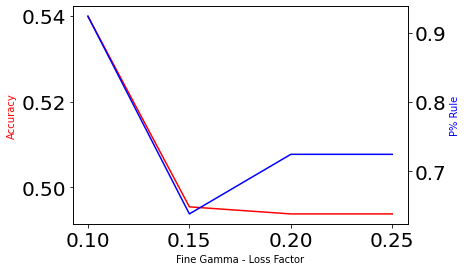

In [167]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list , 'r-')
ax2.plot(gamma_list, p_list, 'b-')

ax1.set_xlabel('Fine Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='r')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Test Accuracy and P% Rule


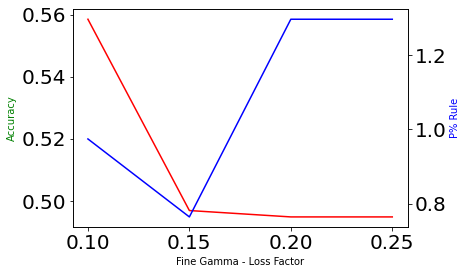

In [168]:
import matplotlib.pyplot as plt
print("Test Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list_test , 'r-')
ax2.plot(gamma_list, p_test, 'b-')

ax1.set_xlabel('Fine Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

In [170]:
acc_total = 0
for x in accuracy_list_test:
    acc_total = acc_total + x
accuracy_test_constrained = acc_total/len(accuracy_list_test)

In [171]:
print("Accuracy of the Actual Model: ", accuracy_test_compas)
print("Accuracy of the Constrained Model: ", accuracy_test_constrained)

Accuracy of the Actual Model:  0.6796714579055442
Accuracy of the Constrained Model:  0.5112936344969199


We have focused on constraining the accuracy in order to make the model fair, so this is the reason that we have the accuracy of the constrained model lower than that of the actual model. 

### Race Specific

Optimizing based on specific race and then finding the calibration of the models. 

In [172]:
def optimization_race(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    cons = {'type':'ineq', 'fun': log_loss_constraint, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(optimize_function,
                               x0=optimal_weights,
                               args= (x_train,protected_attr),
                               method='SLSQP',
                               constraints=cons,
                               options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    
    print("\nTest Accuracy for gamma ",gamma,": ",accuracy_test)
    
    return accuracy_train,pred_y, accuracy_test, y_pred_test


In [173]:
gamma_list = [0.1,0.15,0.2, 0.25]



test_data =[(X_test_AA, y_test_AA, race_test_AA),(X_test_CA, y_test_CA, race_test_CA)]
race_scores=[]
for i in range(len(test_data)):
    if(i == 0):
        print("Race: African American")
    else:
        print("\nRace: Caucasian")
    accuracy_list =  []
    accuracy_list_test = []
    y_pred_train_list = []
    y_pred_test_list = []
    
    for g in gamma_list:    
        (accuracy_train, pred_y, accuracy_test,y_pred_test) = optimization_race(X_train, 
                                                                                        y_train, 
                                                                                        test_data[i][0], 
                                                                                        test_data[i][1], 
                                                                                        race_train,
                                                                                        test_data[i][2],
                                                                                        g,
                                                                                        weights_df)

        accuracy_list.append(accuracy_train)
        y_pred_train_list.append(pred_y)

        accuracy_list_test.append(accuracy_test)
        y_pred_test_list.append(y_pred_test)
    race_scores.append([accuracy_list, y_pred_train_list, accuracy_list_test, y_pred_test_list])

Race: African American

Test Accuracy for gamma  0.1 :  0.5416666666666666

Test Accuracy for gamma  0.15 :  0.4519230769230769

Test Accuracy for gamma  0.2 :  0.44551282051282054

Test Accuracy for gamma  0.25 :  0.44551282051282054

Race: Caucasian

Test Accuracy for gamma  0.1 :  0.5885714285714285

Test Accuracy for gamma  0.15 :  0.5771428571428572

Test Accuracy for gamma  0.2 :  0.5828571428571429

Test Accuracy for gamma  0.25 :  0.5828571428571429


In [174]:
race_accuracy =[]
for x in race_scores:
    total =0
    for acc in x[2]:
        total = total + acc
    race_accuracy.append(total/len(x[2]))
    

In [175]:
y_pred_model2_AA = race_scores[0][3][0]
y_pred_model2_CA = race_scores[1][3][0]

In [176]:
accuracy_model2_AA = race_accuracy[0]
accuracy_model2_CA = race_accuracy[1]

In [177]:
print("Model 1 without Constraints: African American\n")

print(classification_report(y_test_AA, y_pred__model1_AA))  

print("Model 1 without Constraints: Caucasian\n")

print(classification_report(y_test_CA, y_pred__model1_CA))   #Working on the validation data

Model 1 without Constraints: African American

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       134
           1       0.73      0.78      0.75       178

    accuracy                           0.71       312
   macro avg       0.70      0.69      0.70       312
weighted avg       0.70      0.71      0.70       312

Model 1 without Constraints: Caucasian

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       102
           1       0.57      0.49      0.53        73

    accuracy                           0.63       175
   macro avg       0.62      0.61      0.62       175
weighted avg       0.63      0.63      0.63       175



In [178]:
print("Model 2 with Constraints and the best Gamma: African American\n")

print(classification_report(y_test_AA, y_pred_model2_AA))  

print("Model 2 with Constraints and the best Gamma: Caucasian\n")

print(classification_report(y_test_CA, y_pred_model2_CA))   #Working on the validation data

Model 2 with Constraints and the best Gamma: African American

              precision    recall  f1-score   support

           0       0.48      0.77      0.59       134
           1       0.68      0.37      0.48       178

    accuracy                           0.54       312
   macro avg       0.58      0.57      0.54       312
weighted avg       0.59      0.54      0.53       312

Model 2 with Constraints and the best Gamma: Caucasian

              precision    recall  f1-score   support

           0       0.62      0.75      0.68       102
           1       0.51      0.37      0.43        73

    accuracy                           0.59       175
   macro avg       0.57      0.56      0.55       175
weighted avg       0.58      0.59      0.57       175



In [179]:
print("Accuracy of Model 1 without Constraints for Race: African American: ", accuracy_model1_AA)
print("Accuracy of Model 1 without Constraints for Race: Caucasian: ", accuracy_model1_CA)
print("\nAccuracy of Model 2 with Constraints for Race: African American: ", accuracy_model2_AA)
print("Accuracy of Model 2 with Constraints for Race: Caucasian: ", accuracy_model2_CA)

Accuracy of Model 1 without Constraints for Race: African American:  0.7051282051282052
Accuracy of Model 1 without Constraints for Race: Caucasian:  0.6342857142857142

Accuracy of Model 2 with Constraints for Race: African American:  0.47115384615384615
Accuracy of Model 2 with Constraints for Race: Caucasian:  0.5828571428571429


In [181]:
calibration_model1 = abs(accuracy_model1_AA-accuracy_model1_CA)
print("Calibration without Constraints: ", calibration_model1)

accuracy_AA = []
calibration_list = []
accuracy_CA=[]
for acc in range(0,4):
    print("Gamma: ", gamma_list[acc])
    calibration_model2 = abs(race_scores[0][2][acc] - race_scores[1][2][acc])
    calibration_list.append(calibration_model2)
    accuracy_AA.append(race_scores[0][2][acc])
    accuracy_CA.append(race_scores[1][2][acc])
    print("Calibration with Constraints: ", calibration_model2)

df_calibration = pd.DataFrame([''])

Calibration without Constraints:  0.07084249084249095
Gamma:  0.1
Calibration with Constraints:  0.046904761904761894
Gamma:  0.15
Calibration with Constraints:  0.12521978021978025
Gamma:  0.2
Calibration with Constraints:  0.1373443223443223
Gamma:  0.25
Calibration with Constraints:  0.1373443223443223


As the accuracies and calibrations converges after gamma: 0.2, we ignore the values for gamma 0.25

In [190]:
Models = ["Original Model without Constraints", "Model with Constraints", "Model with Constraints", "Model with Constraints"]
gamma_list_1 = [0.1, 0.15, 0.2, 0.25]
gamma_list_1 = ["-"] + gamma_list_1[0:3]
accuracy_AA_1 = [accuracy_model1_AA] + accuracy_AA[0:3]
accuracy_CA_1 = [accuracy_model1_CA] + accuracy_AA[0:3]
calibration_list_1 = [calibration_model1] + calibration_list[0:3]
accuracy_test_datas = [accuracy_test_compas] + accuracy_list_test[0:3]
dict1 = {"Models": Models,
    "Gammas": gamma_list_1, "Accuracy": accuracy_test_datas, "Accuracy_AA": accuracy_AA_1,
        "Accuracy_CA": accuracy_CA_1,
        "Calibration": calibration_list_1}

In [191]:
df_calibration = pd.DataFrame(dict1)
df_calibration

,Models,Gammas,Accuracy,Accuracy_AA,Accuracy_CA,Calibration
0,Original Model without Constraints,-,0.679671,0.705128,0.634286,0.070842
1,Model with Constraints,0.1,0.588571,0.541667,0.541667,0.046905
2,Model with Constraints,0.15,0.577143,0.451923,0.451923,0.125220
3,Model with Constraints,0.2,0.582857,0.445513,0.445513,0.137344


Based on the above results, we can see that on constraining the accuracy for fairness, we find the accuracy of model 2 decrease but subsequently the Calibration of model 2 tends to increase. 

## A7:  Information Theoretic Measures for Fairness-aware Feature selection (FFS)

## Read in Data

In [62]:
import pandas as pd
import numpy as np
import math
import copy
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(18, 16), dpi=180)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

<Figure size 3240x2880 with 0 Axes>

In [63]:
link = ('https://raw.githubusercontent.com/'
        'propublica/compas-analysis/master/compas-scores-two-years.csv')
feature = ['age', 'c_charge_degree', 'race', 'v_score_text', 'sex', 'priors_count', 
           'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid','c_jail_in', 'c_jail_out']
raw = pd.read_csv(link)[feature]
raw.head()

,age,c_charge_degree,race,v_score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Medium,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,Low,Male,2,NaN,1,0,0,NaN,NaN


## Data Cleaning and Transformation

· **Race**: Caucasian (2087) and African-American (3247)

In [64]:
#basic cleaning according to the data page

df = raw[(raw.race == 'Caucasian') | (raw.race == 'African-American')]
df = df[(df.days_b_screening_arrest < 30) & (df.days_b_screening_arrest >= -30)]
df.drop(columns=['days_b_screening_arrest'], inplace = True)
df = df[df.is_recid != -1]
df = df[df.c_charge_degree != 'O']
df['length_of_stay'] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df['c_jail_in'])).dt.days
df.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)

df.head()

,age,c_charge_degree,race,v_score_text,sex,priors_count,decile_score,is_recid,two_year_recid,length_of_stay
1,34,F,African-American,Low,Male,0,3,1,1,10
2,24,F,African-American,Low,Male,4,4,1,1,1
6,41,F,Caucasian,Low,Male,14,6,1,1,6
8,39,M,Caucasian,Low,Female,0,1,0,0,2
10,27,F,Caucasian,Low,Male,0,4,0,0,1


· **Age**: age < 25, 25 < age < 45, age > 45  
· **Charge Degree**: Misdemeanor or Felony  
· **Gender**: Male or Female  
· **Prior Counts**: 0, 1-3, larger than 3  
· **Length of Stay**: <= 1 week, <= 3 months or > 3 months  

In [65]:
## Encoding

catgorical = df.columns[df.dtypes == 'object']
for fea in catgorical:
    new_fea = LabelEncoder().fit_transform(df[fea])
    df[fea] = new_fea
    
df['age_cat'] = pd.cut(df['age'], bins = [0, 25, 45, 100], labels = [0, 1, 2])
df['priors_count_cat'] = pd.cut(df['priors_count'], bins = [-5, 0, 3, np.inf], labels = [0, 1, 2])
df['length_cat'] = pd.cut(df['length_of_stay'], bins = [0, 7, 90, np.inf], labels = [0, 1, 2])
df_clean = df[['race', 'age_cat', 'c_charge_degree', 'sex', 'priors_count_cat', 'length_cat', 'two_year_recid']]
df_clean = df_clean.dropna()
df_clean.head()

# to reproduce the origin experiment in paper A7, we select the age, charge_degree, sex, priors_count
# and length_of_stay as our main features

,race,age_cat,c_charge_degree,sex,priors_count_cat,length_cat,two_year_recid
1,0,1,0,1,0,1,1
2,0,0,0,1,2,0,1
6,1,1,0,1,2,0,1
8,1,1,1,0,0,0,0
10,1,1,0,1,0,0,0


Split the data as training : validation : testing = 5:1:1

In [66]:
# train_test_split

y = df_clean.two_year_recid
X = df_clean.drop(columns=['two_year_recid'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, 
                                                   stratify=y_train, random_state = 123)

In [67]:
# Race as protected attributes(senesitive features)

X_train_sen = np.array(X_train['race'])
X_train = np.array(X_train.drop(columns = ['race']))
X_val_sen = np.array(X_val['race'])
X_val = np.array(X_val.drop(columns = ['race']))

# For calculating calibration, split the test dataset to different race
X_test_AA = np.array(X_test[X_test.race == 0])
X_test_CA = np.array(X_test[X_test.race == 1])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test_AA = np.array(y_test[X_test.race == 0])
y_test_CA = np.array(y_test[X_test.race == 1])

X_test = np.array(X_test)
y_test = np.array(y_test)

### Implementing A7

In [68]:
# shapley value calculation functions

def uniq_vals_in_arr(arr):

    uniq_vals = []
    for id_col in range(arr.shape[1]):
        uniq_vals.append(np.unique(arr[:, id_col]).tolist())
    return uniq_vals


def powerset(seq):

    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item


def info_coef(left, right):
    # Both arrays NEED same number of rows
    assert left.shape[0] == right.shape[0]
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
        
    concat_mat = np.concatenate((left, right), axis=1)
    concat_uniq_vals = uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((right == vec[num_left_cols:]).all(axis=1))[0]) / num_rows
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r1) / p_r1
        p_sum += np.abs(p_iter)
    return p_sum


def conditional_info_coef(left, right, conditional): 
    assert (left.shape[0] == right.shape[0]) and (left.shape[0] == conditional.shape[0])
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
    num_right_cols = right.shape[1]

    right_concat_mat = np.concatenate((right, conditional), axis=1)    
    concat_mat = np.concatenate((left, right_concat_mat), axis=1)
    concat_uniq_vals = uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((concat_mat[:, num_left_cols: -num_right_cols] == vec[num_left_cols: -num_right_cols]).all(axis=1))[0]) / num_rows
        
        try:
            p_r1_given_r3 = len(np.where((concat_mat[:, :num_left_cols] == vec[:num_left_cols]).all(axis=1) & (concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0]) / len(np.where((concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0])
        except ZeroDivisionError:
            p_r1_given_r3 = 0
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0 or p_r1_given_r3 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r2) / p_r1_given_r3
        p_sum += np.abs(p_iter)
    return p_sum


def acc_coef(y, x_s, x_s_c, sensitive):
    conditional = np.concatenate((x_s_c, sensitive), axis=1)
    return conditional_info_coef(y, x_s, conditional)


def disc_coef(y, x_s, sensitive):
    x_s_a = np.concatenate((x_s, sensitive), axis=1)
    return info_coef(y, x_s_a) * info_coef(x_s, sensitive) * conditional_info_coef(x_s, sensitive, y)


def shapley_acc(y, x, sensitive, i):
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        idx_xsc_incl = list(set(list(range(num_features))).difference(set(idx_xs_incl)))
        acc_incl = acc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], x[:, idx_xsc_incl], sensitive.reshape(-1, 1))
        
        # Calculate v(T)
        idx_xsc_excl = list(range(num_features))
        idx_xsc_excl.pop(i)
        idx_xsc_excl = list(set(idx_xsc_excl).difference(set(set_idx)))
        acc_excl = acc_coef(y.reshape(-1, 1), x[:, set_idx], x[:, idx_xsc_excl], sensitive.reshape(-1, 1))
        
        marginal = acc_incl - acc_excl
        shapley = shapley + coef * marginal
    return shapley


def shapley_disc(y, x, sensitive, i):
  
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v_D(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        disc_incl = disc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], sensitive.reshape(-1, 1))
        
        # Calculate v_D(T)
        disc_excl = disc_coef(y.reshape(-1, 1), x[:, set_idx], sensitive.reshape(-1, 1))
        
        marginal = disc_incl - disc_excl
        shapley = shapley + coef * marginal
    return shapley


def shapley(train_set):
    
    shap_acc = []
    shap_disc = []
    for i in range(5):
        acc_i = shapley_acc(train_set[0],train_set[1], train_set[2],i)
        disc_i = shapley_disc(train_set[0],train_set[1], train_set[2], i)

        shap_acc.append(acc_i)
        shap_disc.append(disc_i)
    return [shap_acc, shap_disc]


In [69]:
## Feature Selection Result

train_set = [y_train, X_train, X_train_sen]
shaply = shapley(train_set)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, shaply[0], shaply[1])), columns = ['Features', 'Accuracy', 'Discrimination'])

,Features,Accuracy,Discrimination
0,Age,1.210114,46772.615106
1,Charge Degree,1.087360,37525.470930
2,Gender,0.969253,37630.375782
3,Prior Counts,1.248108,47161.541173
4,Length of Stay,1.190087,46187.281878


**Conclusion**: We Applied the measure of accuracy and discrimination to the dataset. The result shows that **Age** and **Prior Counts** show strongest proxies for discrimination. This is in line with the conclusion of paper A7. However, both features show the strongest proxies for model accuracies as well. Thus, a naive decision to drop **Age** or **Prior Counts** would highly reduce the model accuracy.   

To make a wise decision for fairness-aware feature selection, we can compute the fairness-utility score which is based on the shapley value and a positive hyperparamter $\alpha$. The choice of $\alpha$ helps trade off between accuracy and discrimination.


## Model Selection and Evaluation

### Hyperparameter Tuning

In [70]:

def fairness_score(shaply, alpha):
    shap_score = []
    for i in range(5):
        score = shaply[0][i] - alpha * shaply[1][i]
        
        shap_score.append(score)
    return [shaply[0], shaply[1], shap_score]


**(1) $\alpha = 0.000001$**

In [71]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_1 = fairness_score(shaply, 0.000001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_1[0], score_1[1], score_1[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,1.163341
1,Charge Degree,1.087360,37525.470930,1.049834
2,Gender,0.969253,37630.375782,0.931623
3,Prior Counts,1.248108,47161.541173,1.200947
4,Length of Stay,1.190087,46187.281878,1.143899


**(2) $\alpha = 0.00001$**

In [72]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_2 = fairness_score(shaply, 0.00001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_2[0], score_2[1], score_2[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,0.742387
1,Charge Degree,1.087360,37525.470930,0.712105
2,Gender,0.969253,37630.375782,0.592949
3,Prior Counts,1.248108,47161.541173,0.776493
4,Length of Stay,1.190087,46187.281878,0.728214


**(3) $\alpha = 0.00003$**

In [73]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_3 = fairness_score(shaply, 0.00003)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_3[0], score_3[1], score_3[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-0.193065
1,Charge Degree,1.087360,37525.470930,-0.038404
2,Gender,0.969253,37630.375782,-0.159658
3,Prior Counts,1.248108,47161.541173,-0.166738
4,Length of Stay,1.190087,46187.281878,-0.195532


**(4) $\alpha = 0.00005$**

In [74]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_4 = fairness_score(shaply, 0.00005)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_4[0], score_4[1], score_4[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-1.128517
1,Charge Degree,1.087360,37525.470930,-0.788914
2,Gender,0.969253,37630.375782,-0.912266
3,Prior Counts,1.248108,47161.541173,-1.109969
4,Length of Stay,1.190087,46187.281878,-1.119278


**(5) $\alpha = 0.0001$**

In [75]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_5 = fairness_score(shaply, 0.0001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_5[0], score_5[1], score_5[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-3.467148
1,Charge Degree,1.087360,37525.470930,-2.665187
2,Gender,0.969253,37630.375782,-2.793785
3,Prior Counts,1.248108,47161.541173,-3.468046
4,Length of Stay,1.190087,46187.281878,-3.428642


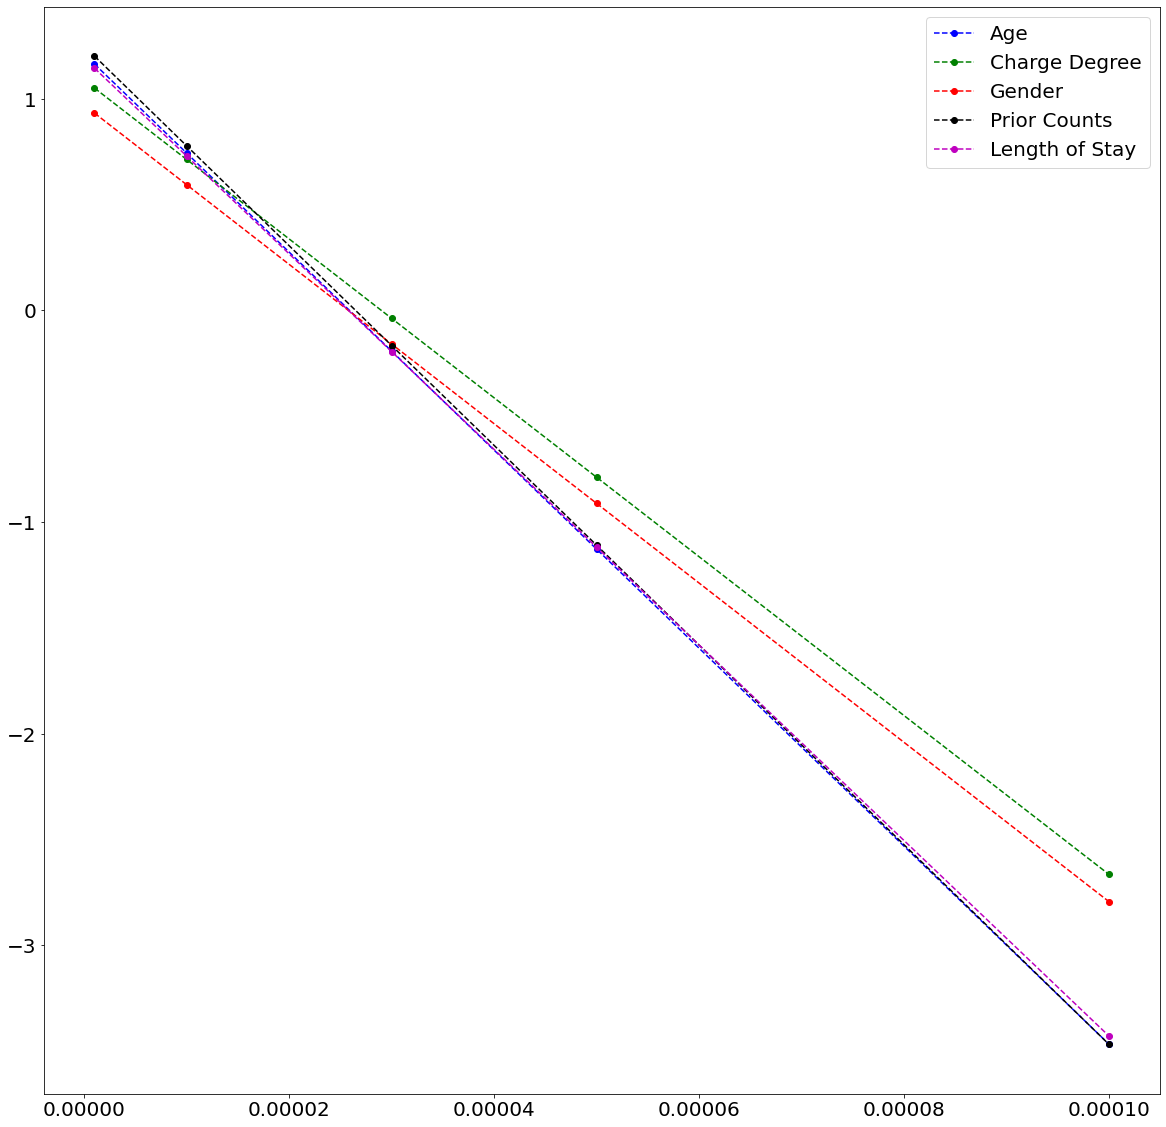

In [76]:
plt.figure(figsize=(20, 20))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)
#xpoints = np.array(['0.000001', '0.00001', '0.00003', '0.00005', '0.0001'])
xpoints = np.array([0.000001, 0.00001, 0.00003, 0.00005, 0.0001])
y_age = np.array([score_1[2][0], score_2[2][0], score_3[2][0], score_4[2][0], score_5[2][0]])
plt.plot(xpoints, y_age, '--bo', label = 'Age')
y_charge = np.array([score_1[2][1], score_2[2][1], score_3[2][1], score_4[2][1], score_5[2][1]])
plt.plot(xpoints, y_charge, '--go', label = 'Charge Degree')
y_gender = np.array([score_1[2][2], score_2[2][2], score_3[2][2], score_4[2][2], score_5[2][2]])
plt.plot(xpoints, y_gender, '--ro', label = 'Gender')
y_prior = np.array([score_1[2][3], score_2[2][3], score_3[2][3], score_4[2][3], score_5[2][3]])
plt.plot(xpoints, y_prior, '--ko', label = 'Prior Counts')
y_length = np.array([score_1[2][4], score_2[2][4], score_3[2][4], score_4[2][4], score_5[2][4]])
plt.plot(xpoints, y_length, '--mo', label = 'Length of Stay')
plt.legend()
plt.savefig('fairness_score.png')

We'd like to remove the feature with the lowest fairness-utility score from the overall five features. From the plot, we observe the lowest fairness-utility score:

1) When $\alpha = 0.000001$ and $\alpha = 0.00001$, **Gender**;

2) When $\alpha = 0.00003$, **Length of Stay**;

3) When $\alpha = 0.00005$, **Age**;

4) When $\alpha = 0.0001$, **Prior Counts**.
    
Basically, if we care about maintaining a very high accuracy, we can choose to remove **Gender**; If we want to minimize the discrimination effect, we can choose to remove **Prior Counts**. 

Next, we will build a set of classification models based on logistic regression. We will first regress on the whole five features, and then remove one feature from **Gender**, **Length of Stay**, **Age**, and **Prior Counts** respectively and compare their accuracy and calibration. 

### Building the model

#### (1) With all 5 features

In [77]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [78]:
y_test_predict_all = lr.predict(np.delete(X_test, 0, axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict_all):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict_all):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict_all):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict_all):.5f}')

AUC:0.68
Precision:0.69
Recall:0.69
Accuracy:0.67967


In [79]:
y_test_predict_AA_all = lr.predict(np.delete(X_test_AA, 0, axis = 1))
y_test_predict_CA_all = lr.predict(np.delete(X_test_CA, 0, axis = 1))
accuracy_AA_all = accuracy_score(y_test_AA, y_test_predict_AA_all)
accuracy_CA_all = accuracy_score(y_test_CA, y_test_predict_CA_all)
print(f'Calibration:{abs(accuracy_AA_all-accuracy_CA_all):.5f}')

Calibration:0.07084


#### (2) Remove Gender

In [80]:
lr2 = LogisticRegression()
lr2.fit(np.delete(X_train, 2, axis = 1), y_train)

LogisticRegression()

In [81]:
y_test_predict2 = lr2.predict(np.delete(X_test, [0, 3], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict2):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict2):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict2):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict2):.5f}')

AUC:0.67
Precision:0.68
Recall:0.69
Accuracy:0.67351


In [82]:
y_test_predict_AA2 = lr2.predict(np.delete(X_test_AA, [0, 3], axis = 1))
y_test_predict_CA2 = lr2.predict(np.delete(X_test_CA, [0, 3], axis = 1))
accuracy_AA2 = accuracy_score(y_test_AA, y_test_predict_AA2)
accuracy_CA2 = accuracy_score(y_test_CA, y_test_predict_CA2)
print(f'Calibration:{abs(accuracy_AA2-accuracy_CA2):.5f}')

Calibration:0.04339


#### (3) Remove Length of Stay

In [83]:
lr3 = LogisticRegression()
lr3.fit(np.delete(X_train, 4, axis = 1), y_train)

LogisticRegression()

In [84]:
y_test_predict3 = lr3.predict(np.delete(X_test, [0, 5], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict3):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict3):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict3):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict3):.5f}')

AUC:0.65
Precision:0.66
Recall:0.69
Accuracy:0.65503


In [85]:
y_test_predict_AA3 = lr3.predict(np.delete(X_test_AA, [0, 5], axis = 1))
y_test_predict_CA3 = lr3.predict(np.delete(X_test_CA, [0, 5], axis = 1))
accuracy_AA3 = accuracy_score(y_test_AA, y_test_predict_AA3)
accuracy_CA3 = accuracy_score(y_test_CA, y_test_predict_CA3)
print(f'Calibration:{abs(accuracy_AA3-accuracy_CA3):.5f}')

Calibration:0.08590


#### (4) Remove Age

In [86]:
lr4 = LogisticRegression()
lr4.fit(np.delete(X_train, 0, axis = 1), y_train)

LogisticRegression()

In [87]:
y_test_predict4 = lr4.predict(np.delete(X_test, [0, 1], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict4):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict4):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict4):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict4):.5f}')

AUC:0.60
Precision:0.60
Recall:0.69
Accuracy:0.59959


In [88]:
y_test_predict_AA4 = lr4.predict(np.delete(X_test_AA, [0, 1], axis = 1))
y_test_predict_CA4 = lr4.predict(np.delete(X_test_CA, [0, 1], axis = 1))
accuracy_AA4 = accuracy_score(y_test_AA, y_test_predict_AA4)
accuracy_CA4 = accuracy_score(y_test_CA, y_test_predict_CA4)
print(f'Calibration:{abs(accuracy_AA4-accuracy_CA4):.5f}')

Calibration:0.09747


#### (5) Remove Prior Counts

In [89]:
lr5 = LogisticRegression()
lr5.fit(np.delete(X_train, 3, axis = 1), y_train)

LogisticRegression()

In [90]:
y_test_predict5 = lr5.predict(np.delete(X_test, [0, 4], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict5):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict5):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict5):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict5):.5f}')

AUC:0.56
Precision:0.56
Recall:0.69
Accuracy:0.56263


In [91]:
y_test_predict_AA5 = lr5.predict(np.delete(X_test_AA, [0, 4], axis = 1))
y_test_predict_CA5 = lr5.predict(np.delete(X_test_CA, [0, 4], axis = 1))
accuracy_AA5 = accuracy_score(y_test_AA, y_test_predict_AA5)
accuracy_CA5 = accuracy_score(y_test_CA, y_test_predict_CA5)
print(f'Calibration:{abs(accuracy_AA5-accuracy_CA5):.5f}')

Calibration:0.06654


### Result

In [188]:
a7_df = pd.DataFrame([['complete model', '/',accuracy_score(y_test, y_test_predict_all), abs(accuracy_AA_all-accuracy_CA_all)],
              ['without gender', '0.000001, 0.00001', accuracy_score(y_test, y_test_predict2), abs(accuracy_AA2-accuracy_CA2)], 
              ['without length of stay', '0.00003', accuracy_score(y_test, y_test_predict3), abs(accuracy_AA3-accuracy_CA3)],
              ['without age', '0.00005', accuracy_score(y_test, y_test_predict4), abs(accuracy_AA4-accuracy_CA4)], 
              ['without prior counts', '0.0001', accuracy_score(y_test, y_test_predict5), abs(accuracy_AA5-accuracy_CA5)]],
             columns = ['Model', 'Alpha', 'Accuracy', 'Calibration'])
a7_df

,Model,Alpha,Accuracy,Calibration
0,complete model,/,0.679671,0.070842
1,without gender,"0.000001, 0.00001",0.673511,0.043388
2,without length of stay,0.00003,0.655031,0.085897
3,without age,0.00005,0.599589,0.097473
4,without prior counts,0.0001,0.562628,0.066538


**Conclusion**: From the shapley value(Accuracy, Discrimination) and fairness-utility score, we expect the model accuracy decreases from the top complete model to the bottom model without prior counts, and the calibration(discrimination effect) should also decrease as the accuracy decreases. The real result shows the decreasing pattern of accuracy as we expected, but the calibration actually fluctuates, which doesn't meet our expectation. Under our evaluation metrics, the logistic regression model without **gender** would probably be the best model when we consider about accuracy and discrimination effect at the same time. It shows a pretty high accuracy with the lowest calibration(discrimination).

There are several possible explanation for the fluctuation of the calibration:

1. Fairness-utility scores are pretty close to each other under our several choices of hyperparameters, so that we cannot guarantee removing the feature with lowest score is always better than removing another feature also with very low score.

2. The marginal accuracy coefficient and marginal discrimination coefficient of the five features are in the same scales. There is no features with outlying discrimiation score or accuracy score. Therefore we didn't observe remarkable differences under our evaluation metrics.

3. Number of test data, proportion of train/test/validation may matters.

In [192]:
print("Algorithm 3")
df_calibration

Algorithm 3


,Models,Gammas,Accuracy,Accuracy_AA,Accuracy_CA,Calibration
0,Original Model without Constraints,-,0.679671,0.705128,0.634286,0.070842
1,Model with Constraints,0.1,0.588571,0.541667,0.541667,0.046905
2,Model with Constraints,0.15,0.577143,0.451923,0.451923,0.125220
3,Model with Constraints,0.2,0.582857,0.445513,0.445513,0.137344


In [193]:
print("Algorithm 7")
a7_df

Algorithm 7


,Model,Alpha,Accuracy,Calibration
0,complete model,/,0.679671,0.070842
1,without gender,"0.000001, 0.00001",0.673511,0.043388
2,without length of stay,0.00003,0.655031,0.085897
3,without age,0.00005,0.599589,0.097473
4,without prior counts,0.0001,0.562628,0.066538
